In [46]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import OrderedDict

In [47]:
# Download the dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

mnist_data = datasets.MNIST(
    root="../data/raw/",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)
dataloader = DataLoader(mnist_data, batch_size=64, shuffle=True)

In [48]:
# check the quantity of the dataset
total_data = 0

for data, label in dataloader:
    total_data+=data.shape[0]

print("The total quantity of the dataset # {}".format(total_data))
print("The shape of the dataset # {} ".format(data.shape))

The total quantity of the dataset # 60000
The shape of the dataset # torch.Size([32, 1, 28, 28]) 


In [49]:
# Call the GPU - MAC
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print("Device # {} ".format(device))

Device # mps 


In [50]:
class Generator(nn.Module):
    """
    A generator class for a Generative Adversarial Network (GAN), particularly used for
    generating images. It takes a latent space vector and a label as input and generates
    images corresponding to the input label. It utilizes fully connected layers and
    LeakyReLU activation for intermediate layers, with a Tanh activation for the output layer.

    Attributes:
        latent_space (int): Dimensionality of the latent space vector (z), which is a random
                            noise input for the generator.
        num_labels (int): Number of unique labels for the conditional GAN. It corresponds to
                          the number of different classes in the dataset.
        labels (nn.Embedding): Embedding layer for the labels, allowing the generator to use
                               label information to generate images corresponding to specific classes.
        layers_config (list): A list defining the architecture of the neural network. Each
                              element in the list is a tuple, with the first two elements
                              being the number of input and output features for a layer,
                              and the optional third being the negative slope for LeakyReLU.
        model (nn.Sequential): The actual neural network model, constructed based on layers_config.
                               It comprises fully connected (Linear) layers, LeakyReLU activation
                               for non-linearity in intermediate layers, and a Tanh activation function
                               in the output layer for generating pixel values.

    Methods:
        connected_layer(layers_config=None):
            Constructs the neural network layers based on layers_config. It initializes the fully
            connected layers and the activation functions, specifically using LeakyReLU for intermediate
            layers and Tanh for the output layer.

        forward(x, labels):
            Performs a forward pass of the generator. It takes a latent space vector `x` and its
            corresponding labels, processes them through the network, and generates a batch of images.

    Note:
        - The latent space vector x should be of the shape (N, latent_space) where N is the batch size.
        - Labels should be of shape (N,) and contain integers representing class labels.
        - The output is a tensor of shape (N, 1, 28, 28), representing generated images of size 28x28 pixels.
    """

    def __init__(self, latent_space=100, num_labels=10):
        self.latent_space = latent_space
        self.num_labels = num_labels
        super(Generator, self).__init__()
        self.labels = nn.Embedding(self.num_labels, self.num_labels)
        self.layers_config = [
            (self.latent_space + self.num_labels, 256, 0.2),
            (256, 512, 0.2),
            (512, 1024, 0.2),
            (1024, 784),
        ]
        self.model = self.connected_layer(layers_config=self.layers_config)

    def connected_layer(self, layers_config=None):
        layers = OrderedDict()
        if layers_config is not None:
            for index, (in_features, out_features, negative_slope) in enumerate(
                layers_config[:-1]
            ):
                layers["{}_layer".format(index)] = nn.Linear(
                    in_features=in_features, out_features=out_features
                )
                layers["{}_activation".format(index)] = nn.LeakyReLU(
                    negative_slope=negative_slope
                )

            (in_features, out_features) = layers_config[-1]
            layers["output_layer"] = nn.Linear(
                in_features=in_features, out_features=out_features
            )
            layers["output_activation"] = nn.Tanh()

            return nn.Sequential(layers)

        else:
            raise Exception("No layers config provided".capitalize())

    def forward(self, x, labels):
        if x is not None:
            labels = labels.long()
            labels = self.labels(labels)
            x = torch.cat([x, labels], dim=1)
            x = self.model(x)
        else:
            raise Exception("No input provided in Generator".capitalize())

        return x.reshape(-1, 1, 28, 28)

In [51]:
# Compute the total trainable parameters
generator = Generator()

total_params = 0
for (_, params) in generator.named_parameters():
    total_params+=params.numel()

print("Total trainable parameters of Generator # {} ".format(total_params).upper())

TOTAL TRAINABLE PARAMETERS OF GENERATOR # 1489012 


In [52]:
g = Generator()
noise_data = torch.randn(64, 100)
data, labels = next(iter(dataloader))

g(noise_data, labels).shape

torch.Size([64, 1, 28, 28])

In [53]:
class Discriminator(nn.Module):
    """
    A discriminator class for a Generative Adversarial Network (GAN), particularly used for
    image data with an added conditional label embedding. The discriminator's goal is to
    differentiate between real and fake images. It utilizes fully connected layers,
    LeakyReLU activation for hidden layers, and a Sigmoid activation for the output layer.

    Attributes:
        num_labels (int): Number of unique labels for the conditional GAN. For instance,
                          in a dataset with 10 different classes, num_labels should be 10.
        labels (nn.Embedding): Embedding layer for the labels, which allows the discriminator
                               to condition the input on a particular class.
        layers_config (list): A list defining the architecture of the neural network. Each
                              element in the list is a tuple, with the first two elements
                              being the number of input and output features for a layer,
                              and the optional third being the negative slope for LeakyReLU.
        model (nn.Sequential): The actual neural network model, constructed based on layers_config.
                              It comprises fully connected (Linear) layers, LeakyReLU activation
                              for non-linearity in hidden layers, and a Sigmoid activation function
                              in the output layer to obtain probabilities.

    Methods:
        connected_layer(layers_config=None):
            Constructs the neural network layers based on layers_config. It initializes the fully
            connected layers and the activation functions, specifically using LeakyReLU for hidden
            layers and Sigmoid for the output layer.

        forward(x, labels):
            Performs a forward pass of the discriminator. It takes an input batch of images `x`
            and their corresponding labels, processes the images and labels through the network,
            and outputs a batch of probabilities indicating how likely each image is to be real.

    Note:
        - The model expects inputs x to be of the shape (N, 784) where N is the batch size.
        - Labels should be of shape (N,) and contain integers representing class labels.
        - The output is of shape (N, 1), representing the likelihood of each image being real.
        - The network architecture is designed to work with flattened images of size 28x28 pixels.
    """

    def __init__(self, num_labels=10):
        self.num_labels = num_labels
        super(Discriminator, self).__init__()
        self.labels = nn.Embedding(self.num_labels, self.num_labels)
        self.layers_config = [
            (784 + self.num_labels, 512, 0.2),
            (512, 256, 0.2),
            (256, 1),
        ]
        self.model = self.connected_layer(layers_config=self.layers_config)

    def connected_layer(self, layers_config=None):
        layers = OrderedDict()
        if layers_config is not None:
            for index, (in_features, out_features, negative_slope) in enumerate(
                layers_config[:-1]
            ):
                layers["{}_layer".format(index + 1)] = nn.Linear(
                    in_features=in_features, out_features=out_features
                )
                layers["{}_activation".format(index + 1)] = nn.LeakyReLU(
                    negative_slope=negative_slope
                )

            (in_features, out_features) = layers_config[-1]
            layers["output_layer"] = nn.Linear(
                in_features=in_features, out_features=out_features
            )
            layers["output_activation"] = nn.Sigmoid()

            return nn.Sequential(layers)
        else:
            raise Exception("Layers config is not defined properly".capitalize())

    def forward(self, x, labels):
        if x is not None:
            labels = labels.long()
            labels = self.labels(labels)
            x = x.reshape(-1, 28 * 28)
            x = torch.cat([x, labels], dim=1)
            x = self.model(x)
        else:
            raise Exception("Inputs are not defined properly".capitalize())

        return x

In [54]:
# Compute the total trainable parameters of Discriminator
discriminator = Discriminator()
total_params = 0

for (_, params) in discriminator.named_parameters():
    total_params+=params.numel()
    
print("Total number of parameters of Discriminator # {} ".format(total_params).upper())

TOTAL NUMBER OF PARAMETERS OF DISCRIMINATOR # 538725 


In [55]:
d = Discriminator()

data, label = next(iter(dataloader))
d(data, label).shape

torch.Size([64, 1])

In [56]:
d = Discriminator()

data = torch.randn(64, 1, 28, 28)

d(data, label).shape

torch.Size([64, 1])

In [57]:
# Define loss and optimizer
loss_function = nn.BCELoss()
learning_rate = 0.0002

optimizer_generator = optim.Adam(
    generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(
    discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.99))

In [61]:
epochs = 50
latent_space = 100
discriminator_loss = []
generator_loss = []

for epoch in range(epochs):
    d_loss = []
    g_loss = []
    for real_samples, labels in dataloader:
        # Convert labels to long, ensuring they are in the correct format for the embedding layer
        labels = labels
        batch_size = real_samples.shape[0]

        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        noise_samples = torch.randn(batch_size, latent_space)
        fake_samples = generator(noise_samples, labels)

        real_predict = discriminator(real_samples, labels)
        fake_predict = discriminator(fake_samples, labels)
        
        real_loss = loss_function(real_predict, real_labels)
        fake_loss = loss_function(fake_predict, fake_labels)

        total_loss = real_loss + fake_loss

        optimizer_discriminator.zero_grad()
        total_loss.backward()
        optimizer_discriminator.step()

        generated_samples = generator(noise_samples, labels)
        generated_predict = discriminator(generated_samples, labels)
        generated_loss = loss_function(generated_predict, real_labels)

        optimizer_generator.zero_grad()
        generated_loss.backward()
        optimizer_generator.step()

        d_loss.append(total_loss.item())
        g_loss.append(generated_loss.item())

    discriminator_loss.append(np.array(d_loss).mean())
    generator_loss.append(np.array(g_loss).mean())

    print("Epochs - {}/{} ".format(epoch + 1, epochs))
    print(
        "[===========] d_loss: {} - g_loss: {} ".format(
            np.array(d_loss).mean(), np.array(g_loss).mean()
        )
    )

Epochs - 1/50 
[===========] d_loss: 1.259218656239897 - g_loss: 1.381320570831868 
Epochs - 2/50 
[===========] d_loss: 1.229176490037426 - g_loss: 1.3951827795393685 
Epochs - 3/50 
[===========] d_loss: 1.1860375160347425 - g_loss: 1.5692751345349782 
Epochs - 4/50 
[===========] d_loss: 1.1229711988968636 - g_loss: 1.789056340387381 
Epochs - 5/50 
[===========] d_loss: 1.06486146072589 - g_loss: 2.042736592958731 
Epochs - 6/50 
[===========] d_loss: 1.0051557914153346 - g_loss: 2.258277844518487 
Epochs - 7/50 
[===========] d_loss: 0.9696998392849334 - g_loss: 2.3721442760180818 
Epochs - 8/50 
[===========] d_loss: 0.9466294205900448 - g_loss: 2.436720581832471 
Epochs - 9/50 
[===========] d_loss: 0.9165750598983724 - g_loss: 2.608846916954146 
Epochs - 10/50 
[===========] d_loss: 0.8811225548926701 - g_loss: 2.626964266874643 
Epochs - 11/50 
[===========] d_loss: 0.8693595882862616 - g_loss: 2.749076666481205 
Epochs - 12/50 
[===========] d_loss: 0.9018676238400596 - g_los

In [72]:
label_names = [
    "Class 0",
    "Class 1",
    "Class 2",
    "Class 3",
    "Class 4",
    "Class 5",
    "Class 6",
    "Class 7",
    "Class 8",
    "Class 9",
]

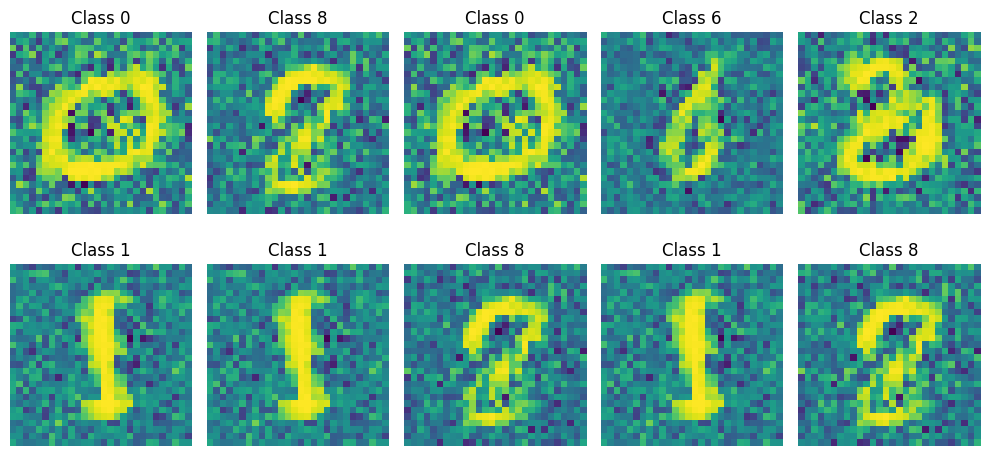

In [82]:
import matplotlib.pyplot as plt

# Set the number of samples you want to generate
num_samples = 10

# Generate noise vectors
fixed_noise = torch.randn(num_samples, latent_space)

# Generate labels for conditional generation
# Here, I'm generating random labels. You can specify labels if you want to generate specific images
fixed_labels = torch.randint(0, num_labels, (num_samples,))  # Random labels

# Generate images
with torch.no_grad():  # We don't need to track gradients here
    generator.eval()  # Set the generator to evaluation mode
    fake_images = generator(fixed_noise, fixed_labels).detach().cpu()
    generator.train()  # Set the generator back to train mode

# Plot the fake images
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples // 2, i + 1)
    plt.imshow(fake_images[i].view(28,28))
    plt.title(
        label_names[fixed_labels[i]]
    )  # Set the title to the corresponding label name
    plt.axis("off")
plt.tight_layout()
plt.show()

In [79]:
fake_images[1][0].shape

torch.Size([28, 28])

In [81]:
fixed_labels

tensor([4, 3, 4, 8, 2, 3, 0, 1, 2, 5])